Métodos estadísticos utilizados

El cálculo de la probabilidad de evento adverso por edad se basa en una combinación de métodos estadísticos descriptivos, de estimación y de suavizado, aplicados de forma híbrida para reflejar la estructura real de los datos.

Densidades de exposición normalizadas
Se construyen distribuciones por edad (P_exp_pob, P_exp_ea) que representan proporciones relativas de exposición dentro del total de prescripciones.

Estadísticamente, esto equivale a una distribución empírica de frecuencias relativas, donde cada edad tiene un peso proporcional a su contribución en el total.

Se normalizan para garantizar que su suma sea 1, permitiendo comparaciones y mezclas coherentes entre fuentes.

Combinación convexa (mezcla híbrida)
El parámetro λ (lambda) define una media ponderada entre dos fuentes de información: la distribución de la población y la observada en los reportes de EA.

Es una forma de estimación por mezcla o blending, que busca equilibrar sesgos: el de subreporte (EA) y el de subrepresentación (población).

Esta técnica es común en métodos bayesianos empíricos y en el ajuste de modelos semi-paramétricos.

Ajuste por subregistro
Se aplica un factor de corrección multiplicativo (por ejemplo, ×20) para compensar el subreporte de casos en la base de datos.

Este tipo de ajuste corresponde a una estimación puntual corregida bajo el supuesto de que sólo una fracción conocida de los casos fue observada.

Estimación de probabilidad condicional
La razón EA_estimated / Presc_est_h estima la probabilidad condicional P(EA | prescripción, edad).

Es una proporción empírica: número de eventos sobre número de exposiciones, ajustada y acotada al intervalo [0,1] para mantener coherencia probabilística.

Suavizado por media móvil
La serie resultante se suaviza mediante una media móvil centrada de ventana k.

Este método es un filtro de promediado que reduce el ruido aleatorio entre edades contiguas sin alterar la tendencia global.

Se prefiere por su simplicidad y porque no introduce supuestos fuertes de forma funcional (a diferencia de un modelo paramétrico).

In [1]:
from pathlib import Path
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

carpeta = Path("data/pred_data")             # tu carpeta
dfs = {
    p.stem: pl.read_parquet(p)          # p.stem = nombre_sin_.parquet
    for p in sorted(carpeta.glob("*.parquet"))
}

# ejemplo de uso:
df_mujeres = dfs["canada_interp_women"]   # si el archivo era canada_interp_women.parquet


In [2]:
import polars as pl

def pop_df(gender: str) -> pl.DataFrame:
    # 1) elegir el DataFrame correcto
    if gender == "Male":
        df = dfs["canada_interp_men"]
    elif gender == "Female":
        df = dfs["canada_interp_women"]
    else:
        df = dfs["canada_interp_total"]

    # 2) detectar el nombre real de la columna de población en el df
    #    ajusta la tupla si usas otro nombre
    pop_col = next(c for c in ("TotalPop", "Total_Pop", "Total_Population", "Canada_Population")
                   if c in df.columns)

    # 3) promedio por edad y orden
    pop_promedio = (
        df
        .group_by("Age")
        .agg(pl.col(pop_col).mean().alias("TotalPop_avg"))
        .sort("Age")
    )

    # 4) proporción poblacional por edad
    pop_proporcion = pop_promedio.with_columns(
        (pl.col("TotalPop_avg") / pl.col("TotalPop_avg").sum()).alias("P_pob")
    )

    return pop_proporcion


In [3]:
def pop_df(gender):
    if gender == 'Male':
        df = dfs["canada_interp_men"]  
        col = 'Men'
    elif gender == 'Female':
        df = dfs["canada_interp_women"]  
        col = 'Women'
    else:
        df = dfs["canada_interp_total"]  
        col = 'Total'
    pop_promedio = (
        df.group_by("Age")
      .agg(pl.col(col).mean().alias("TotalPop_avg"))
      .sort("Age")
        )

    # normaliza para obtener proporción poblacional
    pop_promedio = pop_promedio.with_columns(
        (pl.col("TotalPop_avg") / pl.col("TotalPop_avg").sum()).alias("P_pob")
    )

    return pop_promedio

In [4]:
def ea_df(gender,generation):
    def preparar_total(df: pl.DataFrame, years=None, gen_in=generation, gender=gender) -> np.ndarray:
        d = (
            df.with_columns(
                pl.col("AGE_Y")
                .cast(pl.Utf8)
                .str.extract(r"(\d+)", 1)
                .cast(pl.Int64, strict=False)
                .alias("AGE_Y")
            )
            .filter(pl.col("AGE_Y").is_not_null() & (pl.col("AGE_Y") >= 0) & (pl.col("AGE_Y") <= 100))
        )

        if years is not None:
            d = d.filter(pl.col("YEAR").is_in(list(years)))
        if gen_in is not None and "gen" in d.columns:
            d = d.filter(pl.col("gen").cast(pl.Utf8).str.to_lowercase().is_in([g.lower() for g in gen_in]))
        if gender is not None and "GENDER_ENG" in d.columns:
            d = d.filter(pl.col("GENDER_ENG").cast(pl.Utf8).str.to_lowercase() == gender.lower())

        return d["AGE_Y"].to_numpy()

    def build_df_curva_total(
        df: pl.DataFrame,
        years=None,
        gen_in=None,
        gender=None,
        bins=60,
        window=7
    ) -> pl.DataFrame:
        """Devuelve un DataFrame con la distribución de EA por edad (bruta y suavizada)."""
        ages = preparar_total(df, years=years, gen_in=gen_in, gender=gender)
        if ages.size == 0:
            raise ValueError("No hay datos después de aplicar filtros.")

        # Histograma con bins de 1 año, de 0 a 100
        bins = np.arange(0, 101, 1)  # límites: 0–1, 1–2, ..., 99–100
        counts, edges = np.histogram(ages, bins=bins)

        # Centros: 1, 2, ..., 100 (edad al extremo superior del bin)
        centers = np.arange(1, 101)  # 100 valores enteros de 1 a 100
        y_hist = counts.astype(float)

        # Suavizado con media móvil
        kernel = np.ones(window) / window
        y_smooth = np.convolve(y_hist, kernel, mode="same")

        # Normalizaciones
        total = y_hist.sum()
        y_prop = y_hist / total if total > 0 else y_hist
        smooth_prop = y_smooth / y_smooth.sum() if y_smooth.sum() > 0 else y_smooth

        # Crear DataFrame Polars
        df_out = pl.DataFrame({
            "Age": centers,
            "EA_count": y_hist,
            "EA_smooth": y_smooth,
            "P_EA": y_prop,
            "P_EA_smooth": smooth_prop
        })

        return df_out

    # Ejemplo de uso:
    df_ea = build_df_curva_total(dfs["reports_plus"], bins=45, window=7)
    return df_ea


In [5]:
def juntar_pop_ea(pop_df,ea_df):
    df_merged = (
    pop_df.join(ea_df, on="Age", how="inner")
    .with_columns([
        # ratio relativo: exceso o déficit de EA respecto a la población
        (pl.col("P_EA_smooth") / pl.col("P_pob")).alias("EA_to_Pop_Ratio"),
        # diferencia simple (útil para visualización)
        (pl.col("P_EA_smooth") - pl.col("P_pob")).alias("EA_minus_Pop")
    ])
    .sort("Age")
    )
    return df_merged

In [6]:


def exppermil(generation: str) -> float:
    """
    generation ∈ {"1st gen", "2/3 gen", "4/5 gen"}
    Devuelve el promedio (media) anual de Canada_Prescriptions para esa generación.
    """
    cefs_pl = dfs["cefs"]

    # patrones robustos por generación
    patterns = {
        "1st gen": r"(?i)\b1st\s*gen\b",
        "2/3 gen": r"(?i)\b2\s*/?\s*3(?:rd)?\s*gen\b",
        "4/5 gen": r"(?i)\b4\s*/?\s*5(?:th)?\s*gen\b",
        None: r".*",     # ← permite generation=None (no filtra)
        "all": r".*"     # ← opcional: también acepta "all"
    }
    if generation not in patterns:
        raise ValueError(f"generation inválida: {generation}")

    # filtra la generación (limpia comillas si existen)
    df_gen = cefs_pl.filter(
        pl.col("Antimicrobial_Class")
          .str.replace_all('"', "")
          .str.contains(patterns[generation])
    )

    # suma anual y promedio
    presc_anual = (
        df_gen
        .group_by("Year")
        .agg(pl.col("Canada_Prescriptions").sum().alias("Presc_total_year"))
        .sort("Year")
    )

    presc_general = float(presc_anual["Presc_total_year"].mean())
    return presc_general



In [7]:
def expo(presc_general,df_merged):
    # 1) Exposición proporcional a la población

    df_expos = df_merged.with_columns(
        (pl.lit(presc_general) * pl.col("TotalPop_avg") / 1000).alias("Presc_est_pob")
    )
    sum_p_pob = float(df_expos["Presc_est_pob"].sum())
    df_expos = df_expos.with_columns(
        (pl.col("Presc_est_pob") / sum_p_pob).alias("P_exp_pob")  # densidad (suma=1)
    )

    # 2) Exposición proporcional a la distribución de EA
    #    Total de prescripciones del periodo (sobre toda la población)
    total_pop = float(df_expos["TotalPop_avg"].sum())
    presc_total_all = presc_general * (total_pop / 1000.0)

    #    (a) Usando P_EA_smooth directamente como pesos (ya suma ~1)
    df_expos = df_expos.with_columns(
        (pl.lit(presc_total_all) * pl.col("P_EA_smooth")).alias("Presc_est_ea")
    )

    #    (b) Si prefieres usar EA_smooth bruto: normaliza primero
    sum_ea_smooth = float(df_expos["EA_smooth"].sum())
    df_expos = df_expos.with_columns(
        (pl.lit(presc_total_all) * (pl.col("EA_smooth") / sum_ea_smooth)).alias("Presc_est_ea_from_counts")
    )

    # Densidad de exposición ~ EA (suma=1)
    sum_p_ea = float(df_expos["Presc_est_ea"].sum())
    df_expos = df_expos.with_columns(
        (pl.col("Presc_est_ea") / sum_p_ea).alias("P_exp_ea")
    ).sort("Age")

    return df_expos

In [8]:
def p_ea_hibrido_simple(df_expos: pl.DataFrame, lam: float = 0.7, window: int = 7) -> pl.DataFrame:
    """
    Devuelve un DF con:
      - P_exp_h (densidad híbrida)
      - Presc_est_h (denominador absoluto híbrido)
      - EA_estimated (numerador ajustado ×20)
      - p_age_h (prob por prescripción)
      - p_age_h_smooth (suavizado media móvil)
    Requiere en df_expos: ['Age','EA_smooth','P_exp_pob','P_exp_ea','Presc_est_pob'].
    """
    FACTOR_SUBREG = 20.0 
    
    lam = float(np.clip(lam, 0.0, 1.0))

    # total de prescripciones del periodo (ya lo trae df_expos coherente)
    presc_total_all = float(df_expos["Presc_est_pob"].sum())

    # densidad híbrida (normalizada a suma=1)
    p_raw = lam * df_expos["P_exp_pob"] + (1 - lam) * df_expos["P_exp_ea"]
    p_exp_h = p_raw / float(p_raw.sum())

    # denominador absoluto por edad
    presc_est_h = presc_total_all * p_exp_h

    # numerador: EA ajustados por subregistro
    ea_est = df_expos["EA_smooth"] * FACTOR_SUBREG

    # prob por prescripción
    with np.errstate(divide="ignore", invalid="ignore"):
        p_age_h = (ea_est / presc_est_h).to_numpy()
    # limpia y recorta
    p_age_h = np.nan_to_num(p_age_h, nan=0.0, posinf=0.0, neginf=0.0)
    p_age_h = np.clip(p_age_h, 0.0, 1.0)

    # suavizado (media móvil centrada)
    k = max(1, int(window))
    w = np.ones(k) / k
    p_age_h_smooth = np.convolve(p_age_h, w, mode="same")

    # armar DF de salida
    out = df_expos.select(["Age"]).with_columns([
        pl.Series("P_exp_h",       p_exp_h),
        pl.Series("Presc_est_h",   presc_est_h),
        pl.Series("EA_estimated",  ea_est),
        pl.Series("p_age_h",       p_age_h),
        pl.Series("p_age_h_smooth",p_age_h_smooth),
        pl.lit(lam).alias("lambda")
    ]).sort("Age")

    return out

In [9]:
def p_poredad(df,edad):
   prob_90 = (
        df.filter(pl.col("Age") == edad)
            .select("p_age_h_smooth")
            .item()
    )
   return(prob_90)

In [10]:
from scripts import style
style.mpl_apply()

def wraper(gender=None, generation=None, age=None):
    # generate the pop and ea dfs and join them
    df_pop = pop_df(gender)
    df_ea = ea_df(gender, generation)
    merged = juntar_pop_ea(df_pop, df_ea)
    # with prescriptions see the population exposure
    exp = exppermil(generation)
    expo_df = expo(exp, merged)

    df = p_ea_hibrido_simple(expo_df, lam=0.7, window=7)
    df.sort("Age")

    if age is not None:
        p = p_poredad(df, age)
        percentage = p * 100
        print(
            f"For a person of {age} years (gender: {gender})\n"
            f"the estimated probability of experiencing an adverse event\n"
            f"after a prescription of {generation} generation cephalosporin\n"
            f"is {percentage}%."
        )

    # plot
    plt.figure(figsize=(10, 5))
    plt.plot(df["Age"], df["p_age_h_smooth"], linewidth=2, label="P(AE | age) hybrid (λ=0.7)")
    plt.xlabel("Age")
    plt.ylabel("Probability of AE per Prescription")
    plt.title("Estimated Probability of AE by Age (Hybrid Denominator)")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return df


For a person of 22 years (gender: Female)
the estimated probability of experiencing an adverse event
after a prescription of 2/3 gen generation cephalosporin
is 8.338233690910055%.


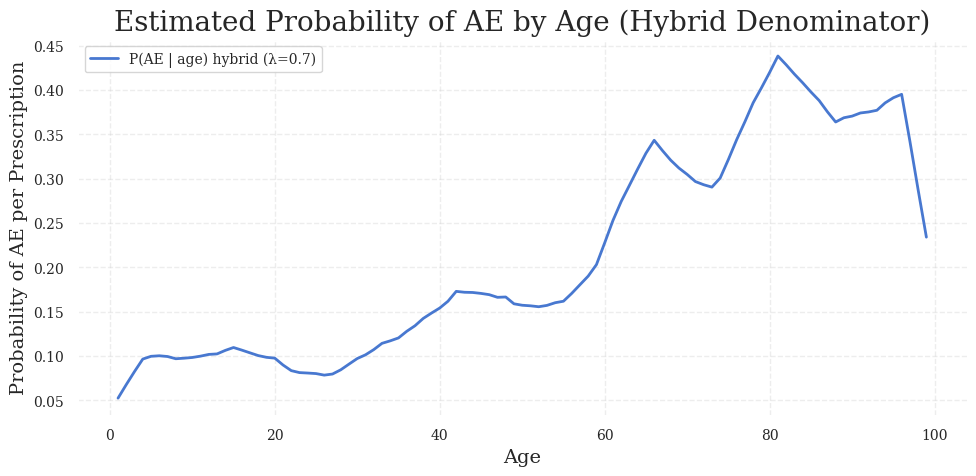

In [11]:
df = wraper( gender = 'Female' ,generation = '2/3 gen', age = 22)

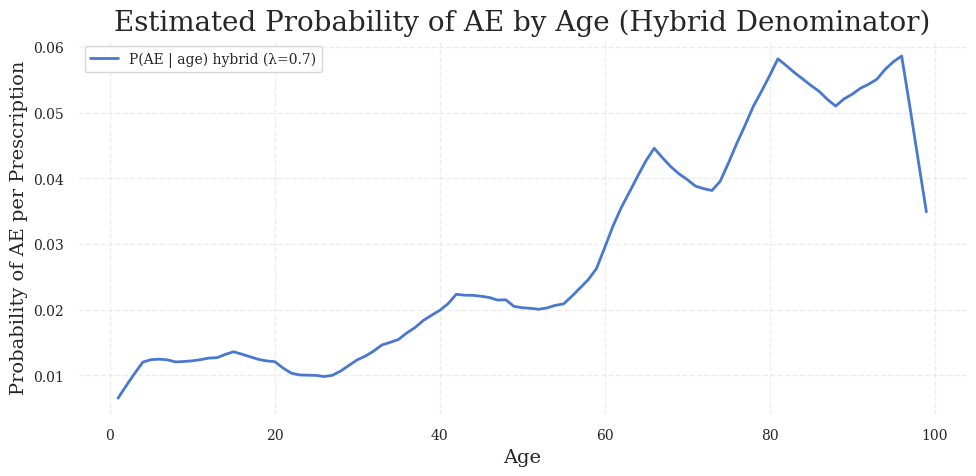

In [12]:
df = wraper()

In [13]:
df

Age,P_exp_h,Presc_est_h,EA_estimated,p_age_h,p_age_h_smooth,lambda
i64,f64,f64,f64,f64,f64,f64
1,0.00769,80712.469106,714.285714,0.00885,0.006512,0.7
2,0.008113,85150.074084,942.857143,0.011073,0.008419,0.7
3,0.008478,88983.292042,1088.571429,0.012233,0.01025,0.7
4,0.008877,93177.399377,1251.428571,0.013431,0.011998,0.7
5,0.009096,95473.645938,1274.285714,0.013347,0.012379,0.7
…,…,…,…,…,…,…
95,0.001273,13358.280566,742.857143,0.05561,0.057776,0.7
96,0.000892,9367.482062,542.857143,0.057951,0.058654,0.7
97,0.000759,7961.628999,497.142857,0.062442,0.050893,0.7


| **Columna**        | **Qué representa**                                       | **Cómo se calcula**                                                                                                                           | **Interpretación**                                                                                                                                                                |
| ------------------ | -------------------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Age**            | Edad (años)                                              | Valor del campo `df_expos["Age"]`.                                                                                                            | Identificador del grupo etario.                                                                                                                                                   |
| **P_exp_h**        | Densidad híbrida de exposición por edad                  | $$ P_{exp_h}(a) = \frac{ \lambda P_{exp_pob}(a) + (1-\lambda) P_{exp_ea}(a) }{\sum_a [\lambda P_{exp_pob}(a) + (1-\lambda) P_{exp_ea}(a)]} $$ | Es la **proporción relativa** de todas las prescripciones que corresponde a cada edad. Es una *densidad* (suma ≈ 1). Combina la forma poblacional y la forma observada en los EA. |
| **Presc_est_h**    | Prescripciones estimadas por edad (denominador absoluto) | $$ Presc_{est_h}(a) = P_{exp_h}(a) \times Presc_{total} $$                                                                                    | Número absoluto estimado de prescripciones en esa edad. Es el **denominador** usado para calcular la probabilidad.                                                                |
| **EA_estimated**   | Eventos adversos estimados (numerador ajustado)          | $$ EA_{est}(a) = EA_{smooth}(a) \times 20 $$ *(factor de subregistro)*                                                                        | Estimación del número real de EA esperados por edad, **corrigiendo el subregistro** (por ejemplo, si solo se reporta el 5 %, se multiplica por 20).                               |
| **p_age_h**        | Probabilidad de EA cruda por prescripción (sin suavizar) | $$ p(a) = \frac{EA_{est}(a)}{Presc_{est_h}(a)} $$                                                                                             | **Probabilidad condicional** $$P(EA \mid prescripción, edad)$$ antes del suavizado. Puede fluctuar más si hay pocos datos por edad.                                               |
| **p_age_h_smooth** | Probabilidad suavizada (media móvil)                     | $$ \tilde{p}(a) = \frac{1}{k} \sum_{i=-k/2}^{k/2} p(a+i) $$                                                                                   | Misma probabilidad pero **suavizada localmente** para reducir ruido. Es la que se grafica e interpreta como la **curva final de riesgo por edad**.                                |
| **lambda**         | Peso de mezcla híbrida                                   | Valor fijo del parámetro $$\lambda$$ usado.                                                                                                   | Indica la ponderación entre las dos fuentes de exposición: población ($$\lambda \to 1$$) y EA observados ($$\lambda \to 0$$).                                                     |
